In [1]:
import numpy as np
from scipy.integrate import solve_bvp, solve_ivp
from matplotlib import pyplot as plt

# Create Model

In [2]:
class salt_lake():
    def __init__(self,k1, k2, params, tf,x0):
        """
        This function initializes the parameters for 
        our model
        parameters:
        -----------
        k1 (float): the first constant in the loss 
        function (multiplied by Q)
        k2 (float): the second constant in the loss 
        function (multipled by R)
        params (dict): a dictionary of the parameters used 
        in A and B
        tf (int): final time
        x0 (array): initial state
        """
        
        # Set Q
        self.Q = np.zeros((4,4))
        self.Q[0,0] = params['k3']

        # Set A
        self.A = lambda t: np.array([[0,params['alpha'],-params['beta'], 0],
                                     [params['epsilon'], 0, 0, params['lambda'](t)],
                                     [params['delta'], 0, 0, params['gamma'](t)],
                                     [0,0,0,0]])

        # Set R 
        self.R = params['k1']
        
        #Set B 
        self.B = lambda t: np.array([params['row'](t), 0, 0, 0]).reshape(-1,1)
        
        # Set M
        M = np.zeros((4,4))
        M[0,0] = params['k2']
        self.M = M          
        
        # Set x0 and final time
        self.x0 = x0
        self.tf = tf
        
    def find_P(self):
        """
        Find the P used in LQR
        """

        # Define ricatti equation
        def ricatti(t,P):
            P = P.reshape((4,4))
            return (- P@self.A(t) - self.A(t).T@P - self.Q
                   + P@self.B(t)*(1/self.R)*(self.B(t)).T@P).reshape(16)

        # Find P
        t_span = (self.tf,0)
        t_eval = np.linspace(self.tf, 0, self.tf+1)
        P0 = self.M.flatten() 

        # our P as defined in (19.8)
        sol = solve_ivp(ricatti, t_span, P0, t_eval=t_eval, dense_output=True)
        return sol.sol
    
    def find_state(self):
        """
        Solve for x
        """
        
        # Get P
        P = self.find_P()

        # Define ricatti equation
        def func(t,x):
            current_P = P(t).reshape((4,4))
            return self.A(t)@x - self.B(t)*1/self.R*(self.B(t)).T@current_P@x     


        # Find P
        t_span = (0,self.tf)
        t_eval = np.linspace(0, self.tf, self.tf+1)
        x0 = self.x0
        sol = solve_ivp(func, t_span, x0, t_eval=t_eval, dense_output=True)
        
        return sol.sol
    
    def find_control(self, t_vals):
        
        # Get P and x
        P = self.find_P()
        x = self.find_state()
        
        # Calculate u
        u = np.array([(-1/self.R*(self.B(t)).T@(P(t).reshape(4,4))@x(t))[0] for t in t_vals])
        
        return u
        
        
        
        

# Set parameters

In [ ]:
3.9/3.3

1.1818181818181819

In [3]:
# Set parameters
alpha = 1 #1    # how depth changes with rainfall (only rain that falls on the lake)
beta = .9 # .96       # how depth changes with evaporation, median saltiness

epsilon = 0.000000005     # the effect of the lake on cloud accumulation and rain per month

# evaporate slightly more than it rains
delta = 0.000000006    #  the depth of the lake impact on evaporation, evaporates slightly more than it rains


def row(t):
  if t <= 60:
    return  0.75
  else:
    return 0


tf = 180 #20

# makes sense bar
k1 = 1 # 1.5 #80         # parameters penalizing pumping 
k2 = 0 #.0001 #-.01            # and end-point depth
k3 = -.000001         # keep very small, punishing depth in our integral

# Set functions
def gamma(t):
    """
    Piece-wise function that averages evaporation per month.
    """
    t = int(t)
    if t%12 == 1:
        return 0
    elif t%12 == 2:
        return 0
    elif t%12 == 3:
        return 2.77/3
    elif t%12 == 4:
        return 5.19/3 - 2.77/3
    elif t%12 == 5:
        return 7.11/3 - 5.19/3
    elif t%12 == 6:
        return 8.8/3 - 7.11/3
    elif t%12 == 7:
        return 9.61/3 - 8.8/3
    elif t%12 == 8:
        return 8.58/3 - 9.61/3
    elif t%12 == 9:
        return 6.1/3 - 8.58/3
    elif t%12 == 10:
        return 3.81/3 - 6.1/3
    elif t%12 == 11:
        return 1.42 - 3.81/3
    elif t%12 == 0:
        return 0 - 1.42
'''def gamma(t):
    """ 
    Piece-wise function that averages evaporation per month.

    """

    #return -1*lambda_(t)

    # 0.00  0.00  2.77  5.19  7.11  8.80  9.61  8.58  6.10  3.81  1.42  0.00

    
    t = int(t)
    if t%12 == 1:
        return 0
    elif t%12 == 2:
        return 0
    elif t%12 == 3:
        return .92
    elif t%12 == 4:
        return .81
    elif t%12 == 5:
        return .64
    elif t%12 == 6:
        return .56
    elif t%12 == 7:
        return .27
    elif t%12 == 8:
        return -.34
    elif t%12 == 9:
        return -.83
    elif t%12 == 10:
        return -.76
    elif t%12 == 11:
        return .15
    elif t%12 == 0:
        return - 1.42'''

def gamma2(t):
  return gamma(t)*2

def lambda_(t):
    t = int(t)
    if t%12 == 1:
        return .1
    elif t%12 == 2:
        return -1
    elif t%12 == 3:
        return -1.2
    elif t%12 == 4:
        return -.3
    elif t%12 == 5:
        return -.2
    elif t%12 == 6:
        return -.8
    elif t%12 == 7:
        return -.4
    elif t%12 == 8:
        return .2
    elif t%12 == 9:
        return .5
    elif t%12 == 10:
        return .3
    elif t%12 == 11:
        return .9
    elif t%12 == 0:
        return 1.9

# Set x0
current_depth = 50272
current_rainfall = 2.4 #50 #47 
current_evaporation = 3.0 #50

x0 = np.array([current_depth, 
               current_rainfall, 
               current_evaporation, 
               1])

# Create parameter dict

params = {'alpha': alpha, 
          'beta':beta, 
          'epsilon':epsilon,
         'delta': delta, 
          'row':row, 
          'gamma':gamma, 
         'lambda': lambda_,
          'k1':k1,
          'k2':k2,
          'k3': k3}

print(' ')

# Solve for state and control

In [4]:
# Find state and control
sl = salt_lake(k1,k2,params,tf,x0)
x = sl.find_state()
t_vals = np.linspace(0, tf, tf+1)
x_vals = x(t_vals)
u = sl.find_control(t_vals)

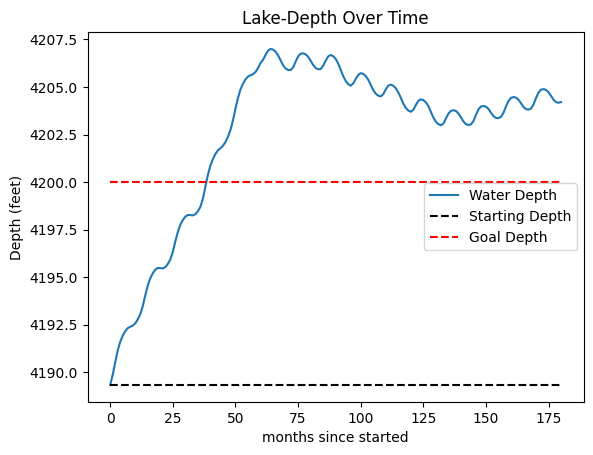

In [11]:
goal_depth = 50400

plt.plot(t_vals, x_vals[0]/12, label='Water Depth')
plt.plot(t_vals, (current_depth*np.ones_like(t_vals))/12, '--k', label='Starting Depth')
plt.plot(t_vals, (goal_depth*np.ones_like(t_vals))/12, '--r', label='Goal Depth')
plt.xlabel('months since started')
plt.ylabel('Depth (feet)')
plt.legend()
plt.title('Lake-Depth Over Time')
plt.show()

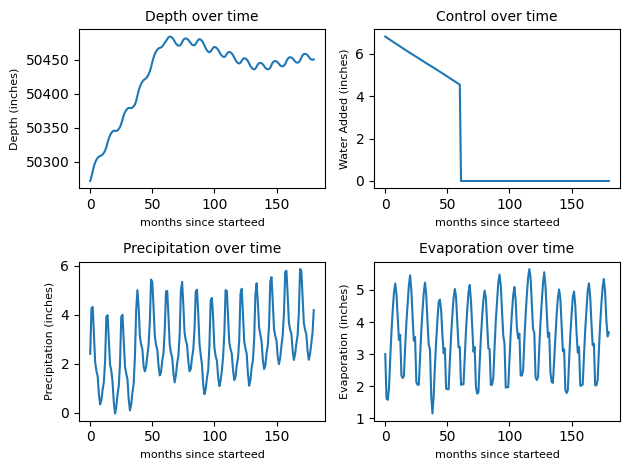

In [9]:
# Plot depth
plt.subplot(2,2,1)
plt.ylabel('Depth (inches)', fontsize=8)
plt.xlabel('months since starteed', fontsize=8)
plt.plot(t_vals, x_vals[0])
plt.title('Depth over time', fontsize=10)

# Plot precipitation
plt.subplot(2,2,3)
plt.plot(t_vals, x_vals[1])
plt.ylabel('Precipitation (inches)', fontsize=8)
plt.xlabel('months since starteed', fontsize=8)
plt.title('Precipitation over time', fontsize=10)

# Plot evaporation
plt.subplot(2,2,4)
plt.plot(t_vals, x_vals[2])
plt.ylabel('Evaporation (inches)', fontsize=8)
plt.xlabel('months since starteed', fontsize=8)
plt.title('Evaporation over time', fontsize=10)

# Plot control
plt.subplot(2,2,2)
plt.plot(t_vals, u)
plt.xlabel('months since starteed', fontsize=8)
plt.ylabel('Water Added (inches)', fontsize=8)
plt.title('Control over time', fontsize=10)
plt.tight_layout()
plt.tight_layout()
plt.show()


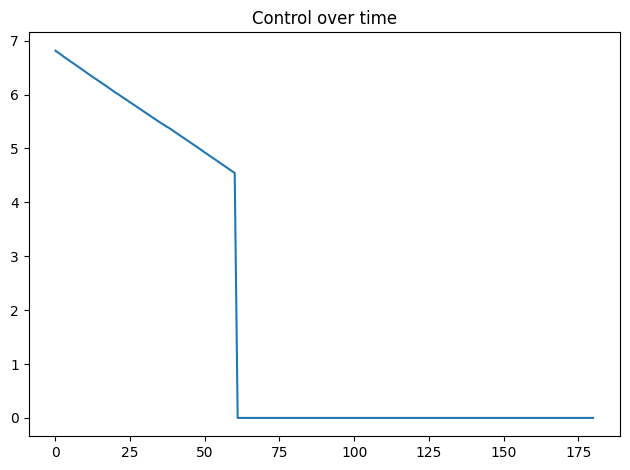

In [24]:

plt.plot(t_vals, u)
plt.title('Control over time')
plt.tight_layout()
plt.show()

In [ ]:
# Set parameters
alpha = .05    # how depth changes with rainfall (only rain that falls on the lake)
beta = .01        # how depth changes with evaporation

# the lake 20% salt

epsilon = .05     # the effect of the lake on clound accumulation and rain
delta = .01      #  the depth of the lake impact on evaporation
row =  .8       # how much our control
tf = 60         # 60 months, 5 years
k1 = .2         # parameters penalizing pumping 
k2 = .0022          # and depth
k3 = .00001         # keep very small, punishing x[tf] in our 

# Set functions
def gamma(t):
    """ 
    Piece-wise function that averages evaporation per month.

    """
    # 0.00  0.00  2.77  5.19  7.11  8.80  9.61  8.58  6.10  3.81  1.42  0.00

def gamma(t):
    """
    Piece-wise function that averages evaporation per month.
    """
    t = int(t)
    if t%12 == 1:
        return 0
    elif t%12 == 2:
        return 0
    elif t%12 == 3:
        return 2.77/3
    elif t%12 == 4:
        return 5.19/3 - 2.77/3
    elif t%12 == 5:
        return 7.11/3 - 5.19/3
    elif t%12 == 6:
        return 8.8/3 - 7.11/3
    elif t%12 == 7:
        return 9.61/3 - 8.8/3
    elif t%12 == 8:
        return 8.58/3 - 9.61/3
    elif t%12 == 9:
        return 6.1/3 - 8.58/3
    elif t%12 == 10:
        return 3.81/3 - 6.1/3
    elif t%12 == 11:
        return 1.42 - 3.81/3
    elif t%12 == 0:
        return 0 - 1.42

        
def lambda_(t):


    t = int(t)
    if t%12 == 1:
        return 60
    elif t%12 == 2:
        return 50
    elif t%12 == 3:
        return 40
    elif t%12 == 4:
        return 40
    elif t%12 == 5:
        return 35
    elif t%12 == 6:
        return 20
    elif t%12 == 7:
        return 10
    elif t%12 == 8:
        return 15
    elif t%12 == 9:
        return 25
    elif t%12 == 10:
        return 40
    elif t%12 == 11:
        return 50
    elif t%12 == 0:
        return 50

# Set x0
current_depth = 50272
current_rainfall = 5
current_evaporation = 1.2

x0 = np.array([current_depth, 
               current_rainfall, 
               current_evaporation, 
               1])

# Create parameter dict

params = {'alpha': alpha, 
          'beta':beta, 
          'epsilon':epsilon,
         'delta': delta, 
          'row':row, 
          'gamma':gamma, 
         'lambda': lambda_,
          'k1':k1,
          'k2':k2,
          'k3': k3}

print(' ')